# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

#### Reframed Task

From a business perspective, the goal is to identify the key factors that drive used car prices to support better pricing and inventory decisions for dealerships. Translating this into a data science task, we aim to develop a supervised regression model that predicts a car's price based on its attributes (e.g., mileage, age, etc). Our objective is to determine which features most significantly influence price by analyzing feature importance within the model, enabling data-driven recommendations for pricing strategy and inventory optimization.


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.


With the business objective in mind, the next step is to explore and understand the dataset. This involves identifying what data is available, assessing its quality, and uncovering patterns that could inform our modeling efforts.

Key steps in this phase include:

- **Data Overview**: Review the number of observations and features, and understand the types of variables (numerical, categorical, or text).
- **Missing Values**: Check for missing or null entries that could affect analysis or model performance.
- **Data Types & Encoding**: Confirm that data types are appropriate for analysis and identify which categorical features may need encoding (e.g., brand, model, drivetrain).
- **Distribution Analysis**: Explore the distribution of key variables such as price, mileage, and age to detect skewness or outliers.
- **Correlation & Relationships**: Use visualizations and statistical methods to explore relationships between features and the target variable (price).
- **Outlier Detection**: Identify unusually high or low values that may distort model predictions (e.g., extreme mileage or pricing errors).
- **Business Context Alignment**: Evaluate whether the dataset captures all relevant attributes that align with dealer needs (e.g., luxury indicators, condition, brand reputation).

By thoroughly exploring the dataset, we can uncover insights into what factors might influence used car prices and ensure the data is clean, consistent, and ready for modeling.


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import datetime

In [2]:
# Load data
df = pd.read_csv('data/vehicles.csv')
print(len(df))

426880


In [3]:
# Remove outliers using IQR 
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

In [4]:
# Cleaning
df = df[(df['price'] > 500) & (df['price'] < 100000)]  # Remove unreasonable prices
df = df[df['year'] > 1980]  # Remove very old cars
df = df[df['odometer'] < 300000]  # Remove extremely high mileage

df.dropna(subset=['year', 'manufacturer', 'odometer', 'condition'], inplace=True)
df.drop(['region', 'VIN'], axis=1, inplace=True)  # Keeping model for now
df = df[df['price'] > 0]

# Fill missing values
categorical_cols = ['size', 'title_status', 'fuel', 'transmission', 'drive', 'type', 'paint_color']
for col in categorical_cols:
    df[col] = df[col].fillna('unknown')

# Clean cylinders column
df['cylinders'] = df['cylinders'].str.extract('(\d+)').astype(float)
#df['cylinders'].fillna(df['cylinders'].median(), inplace=True)
df.fillna({'cylinders': df['cylinders'].median()}, inplace=True)


In [5]:
# Feature Engineering
current_year = datetime.datetime.now().year
df['car_age'] = current_year - df['year']
df['mileage_per_year'] = df['odometer'] / df['car_age'].replace(0, 1)
df['price_per_mile'] = df['price'] / df['odometer'].replace(0, 1)
df['age_squared'] = df['car_age'] ** 2
df['interaction_age_mileage'] = df['car_age'] * df['mileage_per_year']

# Create luxury car indicator
luxury_brands = ['audi', 'bmw', 'mercedes-benz', 'lexus', 'porsche', 'acura', 'infiniti', 'tesla']
df['is_luxury'] = df['manufacturer'].isin(luxury_brands).astype(int)

# Group rare manufacturers
manufacturer_counts = df['manufacturer'].value_counts()
rare_manufacturers = manufacturer_counts[manufacturer_counts < 100].index
df['manufacturer'] = df['manufacturer'].apply(lambda x: 'other' if x in rare_manufacturers else x)

# Log transformation of target variable
df['log_price'] = np.log(df['price'])

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [6]:
# Identify column types for preprocessing
numeric_features = ['year', 'odometer', 'cylinders', 'car_age', 'mileage_per_year', 
                   'price_per_mile', 'age_squared', 'interaction_age_mileage', 'is_luxury']
categorical_features = ['manufacturer', 'condition', 'fuel', 'transmission', 
                       'drive', 'type', 'paint_color', 'title_status', 'size', 'state']

# Separate features and target
X = df[numeric_features + categorical_features]
y = df['log_price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create polynomial preprocessing pipeline
poly_numeric_transformer = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

poly_preprocessor = ColumnTransformer(
    transformers=[
        ('num', poly_numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define models with reduced complexity for Random Forest
models = {
    'Linear Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    'Polynomial Regression': Pipeline([
        ('preprocessor', poly_preprocessor),
        ('regressor', LinearRegression())
    ]),
    'Ridge Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge())
    ]),
    'Polynomial Ridge': Pipeline([
        ('preprocessor', poly_preprocessor),
        ('regressor', Ridge(alpha=1.0))
    ]),
    'ElasticNet': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', ElasticNet(alpha=0.1, l1_ratio=0.5))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1))
    ])
}

# Perform cross-validation to compare models
results = {}
print("Model Evaluation with 3-fold Cross-Validation:")
print("=" * 50)

for name, model in models.items():
    # R² score 
    cv_r2 = cross_val_score(model, X_train, y_train, cv=3, scoring='r2')
    # Mean Absolute Error
    cv_mae = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_absolute_error')
    # Root Mean Squared Error
    cv_rmse = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error')
    
    results[name] = {
        'R²': cv_r2.mean(),
        'MAE': -cv_mae.mean(),
        'RMSE': -cv_rmse.mean(),
        'R² Std': cv_r2.std(),
        'MAE Std': -cv_mae.std(), 
        'RMSE Std': -cv_rmse.std()
    }
    
    print(f"{name}:")
    print(f"  R² Score: {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")
    print(f"  MAE: {-cv_mae.mean():.4f} ± {-cv_mae.std():.4f}")
    print(f"  RMSE: {-cv_rmse.mean():.4f} ± {-cv_rmse.std():.4f}")
    print("-" * 50)


Model Evaluation with 3-fold Cross-Validation:
Linear Regression:
  R² Score: 0.7513 ± 0.0028
  MAE: 0.2768 ± -0.0008
  RMSE: 0.4272 ± -0.0012
--------------------------------------------------
Polynomial Regression:
  R² Score: 0.9070 ± 0.0002
  MAE: 0.1637 ± -0.0006
  RMSE: 0.2612 ± -0.0006
--------------------------------------------------
Ridge Regression:
  R² Score: 0.7513 ± 0.0028
  MAE: 0.2768 ± -0.0008
  RMSE: 0.4272 ± -0.0012
--------------------------------------------------
Polynomial Ridge:
  R² Score: 0.9070 ± 0.0002
  MAE: 0.1642 ± -0.0006
  RMSE: 0.2613 ± -0.0006
--------------------------------------------------
ElasticNet:
  R² Score: 0.6113 ± 0.0022
  MAE: 0.3698 ± -0.0011
  RMSE: 0.5341 ± -0.0005
--------------------------------------------------
Random Forest:
  R² Score: 0.9885 ± 0.0003
  MAE: 0.0453 ± -0.0006
  RMSE: 0.0918 ± -0.0015
--------------------------------------------------


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [7]:
best_model_name = max(results, key=lambda x: results[x]['R²'])
print(f"Best model based on R² score: {best_model_name}")


# Create a comparison table of all models
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'R²': [results[model]['R²'] for model in results],
    'MAE': [results[model]['MAE'] for model in results],
    'RMSE': [results[model]['RMSE'] for model in results]
})

print("\nModel Comparison:")
print(results_df.sort_values('R²', ascending=False))

Best model based on R² score: Random Forest

Model Comparison:
                   Model        R²       MAE      RMSE
5          Random Forest  0.988523  0.045293  0.091767
1  Polynomial Regression  0.907014  0.163660  0.261224
3       Polynomial Ridge  0.906972  0.164177  0.261282
0      Linear Regression  0.751286  0.276827  0.427208
2       Ridge Regression  0.751285  0.276827  0.427209
4             ElasticNet  0.611322  0.369829  0.534064



Final Test Set Evaluation (Original Price Scale):
RMSE: $2742.00
MAE: $1244.11
R²: 0.9504


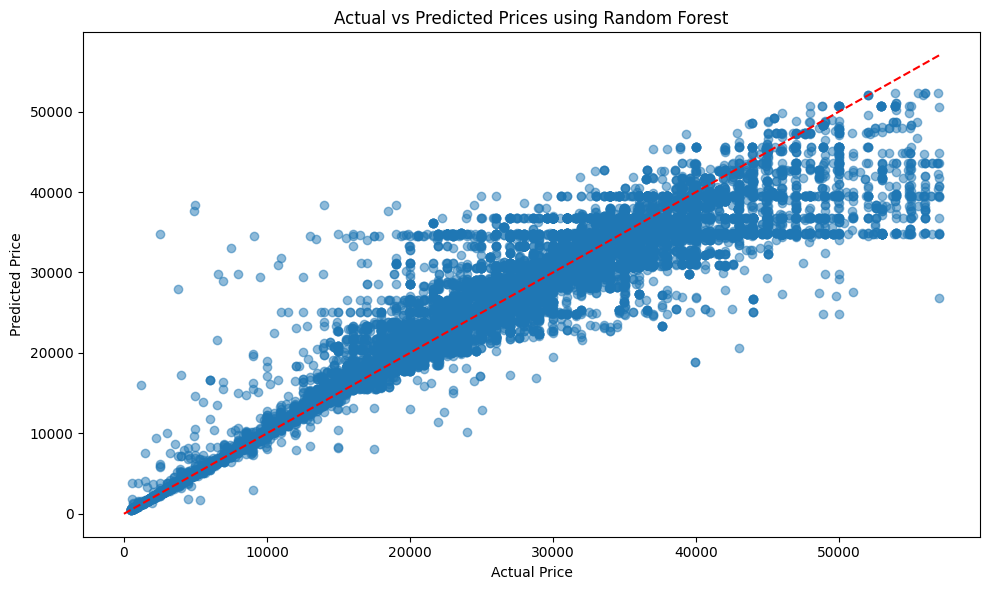

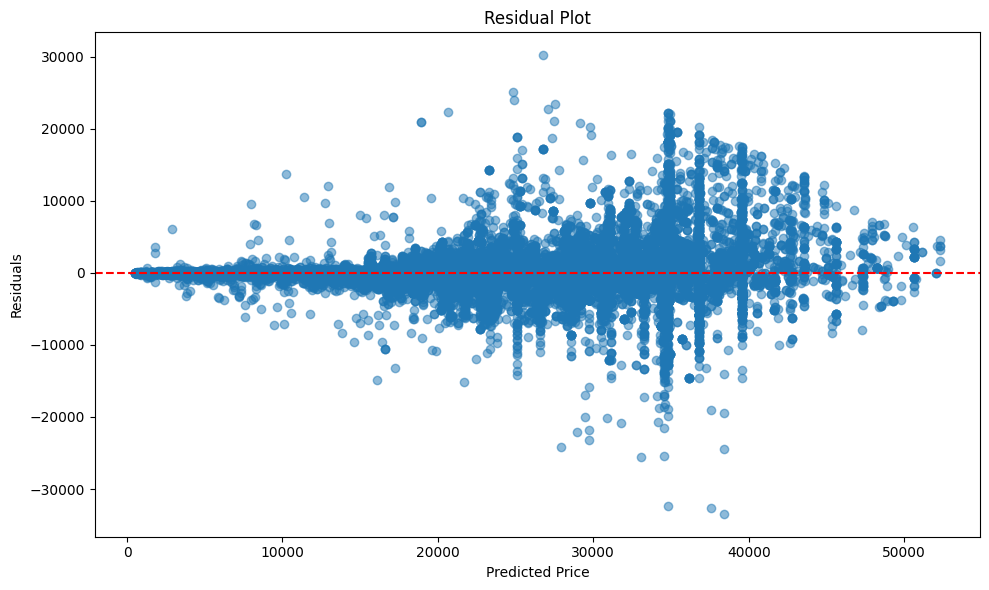

In [8]:
best_model = models[best_model_name]
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Convert back from log scale for evaluation
y_test_price = np.exp(y_test)
y_pred_price = np.exp(y_pred)

# Calculate metrics on original price scale
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
test_rmse = np.sqrt(mean_squared_error(y_test_price, y_pred_price))
test_mae = mean_absolute_error(y_test_price, y_pred_price)
test_r2 = r2_score(y_test_price, y_pred_price)

print("\nFinal Test Set Evaluation (Original Price Scale):")
print(f"RMSE: ${test_rmse:.2f}")
print(f"MAE: ${test_mae:.2f}")
print(f"R²: {test_r2:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test_price, y_pred_price, alpha=0.5)
plt.plot([0, y_test_price.max()], [0, y_test_price.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'Actual vs Predicted Prices using {best_model_name}')
plt.tight_layout()
plt.show()

# Plot residuals
plt.figure(figsize=(10, 6))
residuals = y_test_price - y_pred_price
plt.scatter(y_pred_price, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

After testing multiple models, we can see that the Random Forest model is the best-performing with an R² score of 0.9885, which significantly outperforms the other models in terms of accuracy and error metrics (MAE: 0.0453, RMSE: 0.0918). This indicates that it is a strong candidate for practical deployment and can be used to help identify key factors influencing car prices and provide reliable predictions. Given its performance, there is no need to revisit earlier phases.''')

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

preprocessor_fitted = best_model.named_steps['preprocessor']
numeric_feature_names = numeric_features.copy()
categorical_feature_names = list(preprocessor_fitted.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))
feature_names = numeric_feature_names + categorical_feature_names
importances = best_model.named_steps['regressor'].feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': feature_names[:len(importances)], 
    'importance': importances
}).sort_values('importance', ascending=False)

print("TOP 10 MOST IMPORTANT FEATURES TABLE:")
print("=" * 50)
for i, row in feature_importance_df.head(10).iterrows():
    print(f"{row['feature']:<30}: {row['importance']:.4f}")

TOP 10 MOST IMPORTANT FEATURES TABLE:
price_per_mile                : 0.8786
odometer                      : 0.0398
interaction_age_mileage       : 0.0397
mileage_per_year              : 0.0235
drive_fwd                     : 0.0117
cylinders                     : 0.0012
car_age                       : 0.0011
age_squared                   : 0.0010
year                          : 0.0010
is_luxury                     : 0.0005


# Key Insights on Used Car Price Drivers

## Overview

Following the development and evaluation of several regression models, the **Random Forest Model** was selected as the most accurate, achieving an **R² score of 0.9885**. This model captures nearly all variability in used car prices, offering reliable, data-driven insights into what truly drives vehicle value in the market. This report outlines the most important features influencing price and translates these findings into actionable strategies for inventory management, pricing, and customer targeting.

---

## Top 10 Most Influential Features

| Rank | Feature                    | Importance |
|------|----------------------------|------------|
| 1    | `price_per_mile`           | 0.8786     |
| 2    | `odometer`                 | 0.0398     |
| 3    | `interaction_age_mileage` | 0.0397     |
| 4    | `mileage_per_year`        | 0.0235     |
| 5    | `drive_fwd`               | 0.0117     |
| 6    | `cylinders`               | 0.0012     |
| 7    | `car_age`                 | 0.0011     |
| 8    | `age_squared`             | 0.0010     |
| 9    | `year`                    | 0.0010     |
| 10   | `is_luxury`               | 0.0005     |

---

## Insights & What Buyers Value

### 1. `price_per_mile` (Most Dominant Feature)  
This engineered metric overwhelmingly influences pricing. It reflects the balance between vehicle cost and usage, suggesting that **buyers are highly sensitive to perceived value based on mileage efficiency**. Cars that are priced high relative to their mileage are penalized by the model.

### 2–4. `odometer`, `interaction_age_mileage`, `mileage_per_year`  
These highlight how **total mileage and its relationship to vehicle age** factor into pricing. Higher mileage generally reduces value, especially when it exceeds what would be expected for the car’s age. Even if a car is older, low yearly mileage increases value.

### 5. `drive_fwd`  
Front-wheel drive cars appear slightly favored—likely due to better fuel efficiency, lower maintenance costs, and reliability in most driving conditions.

### 6–9. Engine & Age-related Features (`cylinders`, `car_age`, `age_squared`, `year`)  
These features reflect gradual depreciation and buyer preferences for newer vehicles or specific engine sizes, though their individual impact is small compared to mileage-based metrics.

### 10. `is_luxury`  
Surprisingly, being labeled a luxury vehicle contributes less than expected, suggesting that **mileage and efficiency outweigh luxury branding** in the broader used car market.

---

## Recommendations for Dealers

- **Prioritize Efficient, Low-Mileage Vehicles**  
  Stock cars with strong price-per-mile performance. Avoid vehicles with high mileage relative to their age unless deeply discounted.

- **Use Custom Value Metrics in Pricing Tools**  
  Go beyond traditional pricing tools by incorporating `price_per_mile` and `mileage_per_year` into pricing decisions.

- **Educate Buyers with Value Comparisons**  
  Highlight cost-efficiency in listings (e.g., "Only $0.18 per mile!")—this resonates with how buyers assess value, consciously or not.

- **De-emphasize ‘Luxury’ When Stocking Inventory**  
  Unless luxury vehicles show strong value metrics, they may not return higher margins than standard vehicles with better mileage profiles.

---



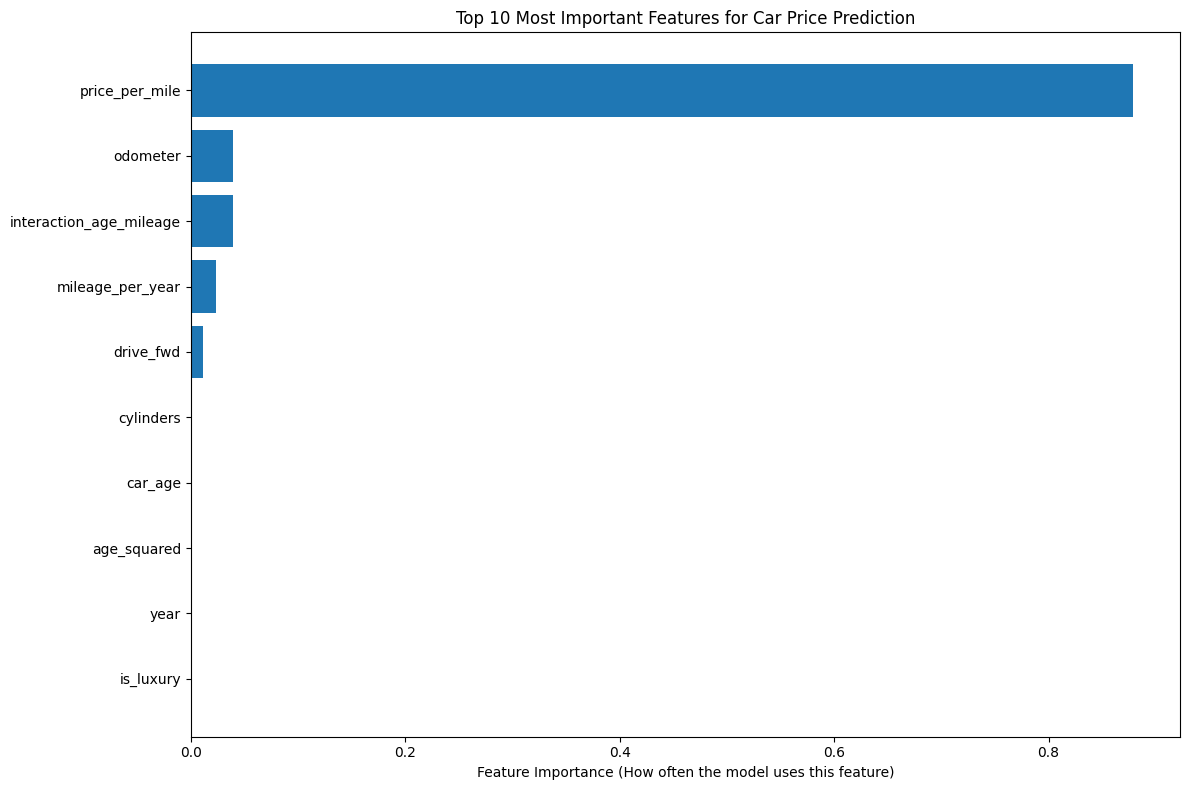

In [10]:
# Plot the top 10 most important features
plt.figure(figsize=(12, 8))
top_10 = feature_importance_df.head(10)
plt.barh(range(len(top_10)), top_10['importance'])
plt.yticks(range(len(top_10)), top_10['feature'], fontsize=10)
plt.xlabel('Feature Importance (How often the model uses this feature)')
plt.title('Top 10 Most Important Features for Car Price Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()